# 0. Loading packages

Uncomment cell below if not all necessary packages are installed

In [1]:
#%pip install numpy
#%pip install matplotlib
#%pip install pandas
#%pip install seaborn
#%pip install scikit-learn
#%pip install missingno
#%pip install imblearn
%pip install xgboost

In [2]:
import warnings

warnings.filterwarnings('ignore')

import self_functions as sf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# 1. Loading data

In [3]:
train_data = pd.read_csv('Datasets/train.csv')
test_data = pd.read_csv('Datasets/test.csv')
test_data_ids = test_data['id']

# 2. Inspecting data

## 2.1 Inspecting missing data

In [ ]:
msno.matrix(train_data)

There is no missing data in the train dataset

In [ ]:
msno.matrix(test_data)

There is no missing data in the test dataset

## 2.2 Inspecting individual columns

In [ ]:
for i in train_data.columns:
    sf.histplot(train_data[i])

There is a low amount of people diagnosed with hypertension and/or heart disease.</br>
The distribution for both the average glucose level and BMI is a right-skewed normal distribution.</br>
There are more women than men in the dataset, there are no people who identify as other in the dataset.</br>
The biggest group of people work at private companies.</br>
There is a 50/50 spread of people living in a rural area vs an urban area.</br>
There is an approximate 50/50 split for people who have ever smoked and people who have never smoked, for the people who have ever smoked it is split 50/50 for active smokers and former smokers.</br>

There is only a low amount of people who have ever had a stroke (imbalanced dataset), which will make it difficult to correctly predict when someone will be having a stroke, therefore later on we will be oversampling the data to make it more useable for machine learning

## 2.3 Datatypes

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33550 entries, 0 to 33549
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              33550 non-null  int64  
 1   age                             33550 non-null  float64
 2   hypertension                    33550 non-null  int64  
 3   heart_disease                   33550 non-null  int64  
 4   avg_glucose_level               33550 non-null  float64
 5   bmi                             33550 non-null  float64
 6   gender_Female                   33550 non-null  bool   
 7   gender_Male                     33550 non-null  bool   
 8   gender_Other                    33550 non-null  bool   
 9   ever_married_No                 33550 non-null  bool   
 10  ever_married_Yes                33550 non-null  bool   
 11  work_type_Govt_job              33550 non-null  bool   
 12  work_type_Never_worked          

## 2.4 Relationships between variables

In [ ]:
sf.corrplot(train_data, 'stroke', 'pearson')

In [ ]:
sf.corrplot(train_data, 'stroke', 'kendall')

In [ ]:
sf.corrplot(train_data, 'stroke', 'spearman')

## 2.5 Minimum requirements for Machine Learning with Scikit Learn

- No missing values: there are no missing values in the dataset which is required for machine learning with Scikit Learn
- Numeric or Boolean values: all columns are in either numeric or Boolean data types which is required for machine learning with Scikit Learn

## 2.6 Conclusion

# 3. Data preparation 

## 3.1 Column selection

In order to avoid multicollinearity, it is important to drop at least one column for every feature. If this is not done, the model can always use the other features to describe the last feature of a certain group (e.g. smoking_status) which would lead to performance issues. 

For example "smoking_status_smokes" could then be explained like this: 

smoking_status_smokes + smoking_status_never + smoking_status_formerly = 1 
then follows: 
smoking_status_smokes = 1 - (smoking_status_never smoked + smoking_status_formerly smoked)  

This makes its more difficult to capture the individual effect of each feature. 

Especially for linear models (e.g. Logistic Regression) this is problematic because they assume independent features. 
While this might not be as important for Tree-based models (they split based on feature values and not coefficients), it still makes sense to drop one feature per group. There is no loss in information as well because its still implicitly known. 

Additionally, columns like "id", "ever_married_yes", "Residence_type_Urban" can be dropped because they offer no additional information. 

In [378]:
col_to_drop = ['id', 'gender_Male', 'gender_Other', 'ever_married_Yes', 'Residence_type_Urban', 'work_type_Private', 'smoking_status_never smoked' ]

train_data = train_data.drop(col_to_drop, axis=1)
test_data = test_data.drop(col_to_drop, axis=1)

## 3.2 Remove outliers

For average glucose levels and BMI we have an extreme right-skewed. Therefore we will be removing the outliers using the Z-score, all values with a Z-score above 3 will be removed.

In [379]:
bmi_zscore = sf.z_score(train_data['bmi'])
glucose_zscore = sf.z_score(train_data['avg_glucose_level'])

train_data['bmi'] = bmi_zscore
train_data['avg_glucose_level'] = glucose_zscore

train_data = train_data[(train_data['bmi'] < 3) & (train_data['avg_glucose_level'] < 3)]

## 3.3 Feature selection

After running all the models, we calculated the feature importances and put them in this table:
![](Figures/output_table_1.png)
We decided to drop all the features with a feature importance below 0.05

In [380]:
cols_to_drop = ['Residence_type_Rural', 'gender_Female', 'bmi', 'smoking_status_formerly smoked', 'work_type_Never_worked', 'work_type_Govt_job']

train_data = train_data.drop(cols_to_drop, axis=1)
test_data = test_data.drop(cols_to_drop, axis=1)

## 3.4 Creating X and y

In [381]:
X_train = train_data.drop('stroke', axis=1)
y_train = train_data['stroke']

## 3.5 Data sampling

Check how many True/False values there are in the train set

In [ ]:
y_train.value_counts()

In [383]:
#rus = RandomUnderSampler()
#
#X_train, y_train = rus.fit_resample(X_train, y_train)

In [384]:
#smote = SMOTE()
#
#X_train, y_train = smote.fit_resample(X_train, y_train)

Check how many True/False values there are in the train set

In [ ]:
y_train.value_counts()

## 3.6 Standardizing data

The columns containing data of the float type will be standardized using Scikit Learn's standardscaler. It is important to standardize the data, this prevents columns with high values to have an unreasonably large impact. The way the standarscaler scales is using the standard deviation and the mean to calculate the Z-score

In [386]:
sc = StandardScaler()

sf.sta_sca(sc, X_train, ['age', 'avg_glucose_level'])
sf.sta_sca(sc, test_data, ['age', 'avg_glucose_level'])

# 5. Models

## 5.1 K-Nearest Neighbours

KNN is a simple, instance-based learning algorithm. We start by tuning the hyperparameters (number of neighbors, weights, and algorithms) to find the best-performing configuration. After tuning, we train the model and use it to make predictions.

#### Foundation

The distance between two data points determines the similiarity:

There are 2 different ways to measure the distance:

1. Euclidean Distance: 
The euclidean distance is the distance of a straight line between two points and its defined as:

![](KNN_EXP1.png)

2. Manhattan Distance: 
The manhattan distance is the absolute differences of the cartesian coordinates of two data points.

![](KNN_EXP2.png)


Regardless of which distance measurement you choose, the classification of a new data point is based on a majority vote among it's k-nearest neighbors.
The predicted value is the average value of the values the k-nearest neighbors hold.

#### Importance of Standardization

The KNN-model uses distance to predict new values. This is fine as long as all values in the dataset have similiar scales. If they dont, features with higher scales will always overshadow smaller-scaled features. A good example for this would be Body-Height versus Body-Weight. Are person can easily weigh 100kgs, but is not bigger than 2 metres. Without standardization, the distance metric would be skewed and the predictions would be heavily influenced by certain features. 

Therefore, standardization leads to higher accuracy and prevents bias.

#### Regularisation in KNN


Regularization is used to prevent overfitting, which happens when the model fits the training data too closely and performs poorly on new data. Regularization adds a penalty to the loss function to discourage the model from using very large coefficients (which can lead to overfitting).

1. Regulating the number of k:

    Effect: Choosing an appropriate number of ks balances the variance-bias trade-off (too small versus k too big k - as already mentioned above).
    
2. Feature Selection/Dimension Reduction:

    Effect: The more features exist, the less important distance metrics become. It is therefore important to reduce the amount of features to a point where only the most importanc components capture the most variance (ignoring unnecessary features that overcomplicate the dataset).

3. Weighting Schemes: 

    By determining the influence of neighbors based on their distance for example, the more relevant data points are emphasized

4. Choice of distance metrics: 

    The choice of the distance metric depends on nature of the dataset. For example, Manhattan distance performs better on high-dimensional, sparse datasets. 

Regularization and Overfitting:

Overfitting happens when a model fits the training data too closely, capturing not only the patterns but also the noise in the data. This leads to poor performance on new (unseen) data.
    Regularization helps to combat overfitting by penalizing large coefficients, which makes the model simpler and more generalizable. This ensures that the model does not rely too heavily on any single feature or a small set of features.

Effect of Regularization:

Without regularization: The model might have large coefficients, which leads to high variance and overfitting.
With regularization: Coefficients are constrained, which reduces the risk of overfitting and increases the model’s ability to generalize to new data.

### 5.1.1 Hyperparameter tuning

#### Hyperparameters to Tune in KNN:

In KNN, we can adjust several hyperparameters to improve model performance. The key hyperparameters include:

    Number of neighbors (penalty):
        Specifies the number of closest neighbors to consider for making new predictions.

        Small k: A small k might be better at capturing local patterns but at the same time might lead to overfitting because it is too sensitive to noise.
        Big k: A big k ensures a more stable model but it might lead to underfitting because it fails to capture local patterns (increased bias).

    Distance metrics (C):
        Euclidean Distance:
        Manhattan Distance: If C is small (like 0.01), the model is heavily regularized. If C is large (like 100), the model is lightly regularized.

    Weighting scheme:
        Specifies the weight given to neighbours:
        
        Uniform Weight: All neighbours have the same weight (= similiar influence).
        Distance Weight: Closer neighbours have bigger weight(=higher influence).
        
    Algorithm (class_weight):
        This hyperparamter specifes the methods used to compute the nearest neighbors. The choice depends on the structure/complexity of the dataset.

We use GridSearchCV to optimize our hyperparameters. 


In [387]:
knn = KNeighborsClassifier()

param_grid = {'n_neighbors': [1, 2, 3, 4, 5], 'weights': ['uniform'], 'algorithm': ['ball_tree', 'kd_tree', 'brute']}
knn_cv = GridSearchCV(estimator=knn, param_grid=param_grid, cv=10, scoring='f1', n_jobs=-1)

### 5.1.2 Training KNN

In [ ]:
knn_cv.fit(X_train, y_train)
print("Best parameters: ", knn_cv.best_params_)
print("Best cross-validation score: ", knn_cv.best_score_)

### 5.1.3 Predicting KNN

In [389]:
knn_pred = knn_cv.predict(test_data)

knn_pred_df = test_data_ids.to_frame()
knn_pred_df['stroke'] = knn_pred

### 5.1.4 Writing to CSV

In [390]:
knn_pred_df.to_csv('Datasets/Predictions/knn_pred.csv', index=False)

## 5.2 Logistic Regression

Logistic Regression is a linear model often used for binary classification tasks like this. It models the probability that a given instance belongs to the positive class (stroke) using a logistic function. We will tune the regularization parameter `C` and different solvers to find the best model.

### Mathematical Foundation

The formula for Logistic Regression can be expressed as follows:

![](LR_Exp1.png)

Where:
— P(Y=1|X): Probability of the target variable being 1 given the input features X.
— β₀, β₁ : Coefficients that need to be learned from the training data.
— X₁, X₂ : Input features.

### Binary cross-entropy / log loss
To evaluate how well the model is performing, we use a loss function. The goal of training the model is to minimize this loss.

![](LR_EXP2.png)

where y is the label (1 for stroke and 0 for no stroke for exapmle) and p(y) is the predicted probability of a stroke for all N points.

Reading this formula, it tells that, for stroke (y=1), it adds log(p(y)) to the loss, that is, the log probability of it being a stroke. Conversely, it adds log(1-p(y)), that is, the log probability of no stroke, for each no stroke (y=0). 

Gradient Descent is an optimization algorithm used in Logistic Regression (and many other models) to find the best parameters (or weights) that minimize the model's error. 

θ=θ−α⋅∇J(θ)

    θθ: Current weight values.
    αα: Learning rate (controls the step size).
    ∇J(θ)∇J(θ): Gradient of the loss function with respect to θθ.

Regularization in Logistic Regression:

Regularization is used to prevent overfitting, which happens when the model fits the training data too closely and performs poorly on new data. Regularization adds a penalty to the loss function to discourage the model from using very large coefficients (which can lead to overfitting).

1. L1 Regularization (Lasso):

    Effect: L1 regularization encourages the model to reduce the size of the coefficients and can even force some of them to be exactly zero. This helps in feature selection, as irrelevant features are removed.
    
2. L2 Regularization (Ridge):

    Effect: L2 regularization discourages large coefficients by penalizing their squared values. This helps reduce overfitting, as it makes the model less sensitive to small changes in the input data.
    
3. ElasticNet:

    ElasticNet is a combination of both L1 and L2 regularization, combining the strengths of both.

Regularization and Overfitting:

Overfitting happens when a model fits the training data too closely, capturing not only the patterns but also the noise in the data. This leads to poor performance on new (unseen) data.
    Regularization helps to combat overfitting by penalizing large coefficients, which makes the model simpler and more generalizable. This ensures that the model does not rely too heavily on any single feature or a small set of features.

Effect of Regularization:

Without regularization: The model might have large coefficients, which leads to high variance and overfitting.
With regularization: Coefficients are constrained, which reduces the risk of overfitting and increases the model’s ability to generalize to new data.

### 5.2.1 Hyperparameter tuning

#### Hyperparameters to Tune in Logistic Regression:

In Logistic Regression, we can adjust several hyperparameters to improve model performance. The key hyperparameters include:

    Penalty (penalty):
        Specifies the type of regularization used: 'l1', 'l2', 'elasticnet', or None (no regularization).

    Inverse Regularization Strength (C):
        Controls the strength of regularization. Smaller values of C imply stronger regularization (more penalty on large coefficients).
        Example: If C is small (like 0.01), the model is heavily regularized. If C is large (like 100), the model is lightly regularized.

    Solver (solver):
        Specifies the algorithm used to optimize the model. Common solvers include:
            'lbfgs': A popular solver for smaller datasets.
            'saga': A solver that supports both L1 and L2 regularization.
            'liblinear': Suitable for smaller datasets but only works with L1 and L2 penalties.

    Class Weight (class_weight):
        This handles class imbalance by adjusting the weights associated with classes, making sure the model doesn’t overemphasize the majority class.


In [391]:
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2', 'elasticnet', None], 'C': [0.001, 0.01, 0.1, 1.0], 'solver': ['liblinear', 'newton-cholesky']}
lr_cv = GridSearchCV(estimator=lr, param_grid=param_grid, cv=10, scoring='f1', n_jobs=-1)

### 5.1.2 Training LR

In [ ]:
lr_cv.fit(X_train, y_train)
print("Best parameters: ", lr_cv.best_params_)
print("Best cross-validation score: ", lr_cv.best_score_)

### 5.1.3 Predicting LR

In [393]:
lr_pred = lr_cv.predict(test_data)

lr_pred_df = test_data_ids.to_frame()
lr_pred_df['stroke'] = lr_pred

### 5.1.4 Writing to CSV

In [394]:
lr_pred_df.to_csv('Datasets/Predictions/lr_pred.csv', index=False)

## 5.3 SVM

SVM is a model that aims to seperate data points into different classes by using a hyperplane and keeping maximum margin at the same time. The hyperplane is a decision boundary that seperates these groups. Margin describes the gap between the hyperplane and the closest points of each class. These close points are called support vectors. 

#### Mathematical Foundations & small example using our dataset

#TO-DO

#### Kernel & Kernel Trick

In general, a Kernel describes the similarity between two datapoints. In a ML context, they help to capture complex patterns and can handle non-linear relationsships by transforming data into higher dimensions. 
If it is not possible to simply seperate the different data points by a straight hyperplane because of their distribution, the Kernel Trick can help. 
The kernel trick simply means to transform the data into a higher dimensional space (from 2D to 3D for example). This might make it possible to seperate the data more easily. 

### 5.3.1 Hyperparameter tuning

#### Regularization in SVM


- L1 Regularization: L1 Regularization mainly aims at feature selection and getting rid (reducing the weight of some features to 0) of less important features. This should result in a simpler model.  However, the selection process of "less important" features done by the L1 Regularization can lead to removing important features (in a dataset with muliple equally important features) which can make the model unstable. Especially in situations with more features than samples, L1 Regularization becomes unstable. 

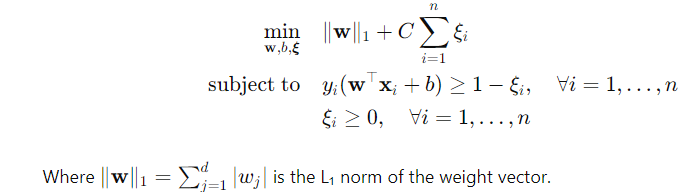
 
- L2 Regularization: Mainly, L2 Regularization promotes larger margins between classes which prevents the data better from overfitting and handling new data better. It does that by penalizing the square of weights (large coefficients are penalized) but it doesnt reduce them to 0. All features therefore stay in the model. 

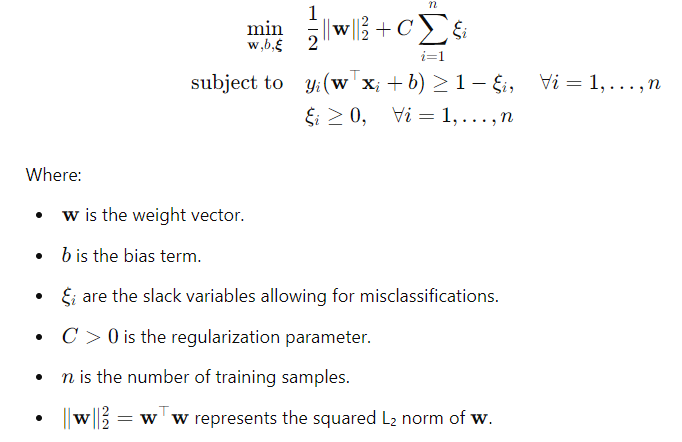

- C Parameter Regularization: The C parameter balances the decision between stricly classifing every data point correctly and allowing some mistakes in order to achieve a more generalizable seperation.  A high C increases the risk of overfitting, while a lower C intentionally allows misclassification.  

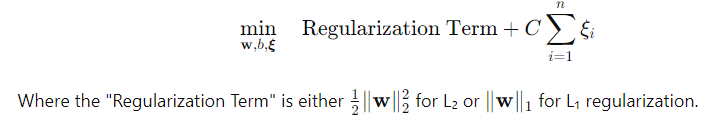

#### Hyperparameter tuning

In Logistic Regression, we can adjust several hyperparameters to improve model performance. The key hyperparameters include:

    Kernel (penalty):
        Specifies the type of kernel used: 'l1', 'l2', 'elasticnet', or None (no regularization).

    Regularization Parameter (C):
        Controls the strength of regularization. Higher values of C imply stronger regularization (more penalty on large coefficients).
        Example: If C is high (like 100), the model is heavily regularized. If C is small (like 0.01), the model is lightly regularized.

    Gamma:
        Gamma controls how strongly each data point is considered during the training process. Setting the value to 'auto' means that the model can decide on its own. 

    Degree Parameter (only for polynomial kernels):
        The degree defines the complexity of the decision boundary that seperates the different models. Each degree allows the decision boundary to bend more often which enables better seperation. 



In [395]:
svc = SVC()

param_grid = {'kernel': ['linear', 'poly', 'rbf'], 'degree': [2, 3, 4, 5], 'gamma': ['auto'], 'C': [0.001, 0.01, 0.1, 1.0]}
svc_cv = GridSearchCV(estimator=svc, param_grid=param_grid, cv=10, scoring='f1', n_jobs=-1)

### 5.3.2 Training SVC

In [ ]:
svc_cv.fit(X_train, y_train)
print("Best parameters: ", svc_cv.best_params_)
print("Best cross-validation score: ", svc_cv.best_score_)

### 5.3.3 Predicting SVC

In [397]:
svc_pred = svc_cv.predict(test_data)

svc_pred_df = test_data_ids.to_frame()
svc_pred_df['stroke'] = svc_pred

### 5.3.4 Writing to CSV

In [398]:
svc_pred_df.to_csv('Datasets/Predictions/svc_pred.csv', index=False)

## 5.4 Decision Tree

A Decision Tree is a non-parametric model that makes predictions by recursively splitting the data into smaller subsets based on feature values. Each internal node in the tree represents a decision based on a feature, and each leaf node represents a predicted outcome (class).

### Splitting Criteria

The two most common criteria for making splits in a decision tree are:

1. **Gini Impurity**:
    Gini Impurity measures how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the class distribution in the node. Lower Gini implies purer nodes.

2. **Entropy (Information Gain)**:
   Entropy measures the impurity in a node, and the goal is to maximize the **Information Gain** (difference in entropy before and after the split) to create pure nodes.


### 5.4.1 Hyperparameter tuning

The best hyperparameters for a Decision Tree include:

- **Max Depth**: Limits the depth of the tree. A deeper tree can model more complex patterns but may overfit.
- **Min Samples Split**: The minimum number of samples required to split an internal node.
- **Min Samples Leaf**: The minimum number of samples required to be at a leaf node.

We determined the best hyperparameters using **GridSearchCV** and the results are displayed below:
```python
print("Best parameters: ", dt_cv.best_params_)


### Pruning and Overfitting

**Pruning** is the process of removing parts of the tree that do not provide additional predictive power. This helps in reducing the complexity of the model and preventing overfitting. There are two main forms of pruning:

1. **Pre-Pruning** (Early Stopping):
   - Pre-pruning stops the tree from growing too large by limiting the depth of the tree, minimum samples at a split, or minimum samples at a leaf. This prevents the model from becoming overly complex.

2. **Post-Pruning**:
   - After the tree is fully grown, post-pruning removes branches that have little importance. This is done by analyzing the performance of the tree on validation data and removing branches that do not improve generalization.

#### Pruning and Underfitting

While pruning reduces overfitting, it is important not to prune too much, as this could lead to **underfitting**, where the tree is too simple to capture the underlying patterns in the data.


In [399]:
dt = DecisionTreeClassifier()

param_grid = {'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'max_features': ['auto', 'sqrt', 'log2']}
dt_cv = GridSearchCV(estimator=dt, param_grid=param_grid, cv=10, scoring='f1', n_jobs=-1)

### 5.4.2 Training DT

In [ ]:
dt_cv.fit(X_train, y_train)
print("Best parameters: ", dt_cv.best_params_)
print("Best cross-validation score: ", dt_cv.best_score_)

### 5.4.3 Predicting DT

In [401]:
dt_pred = dt_cv.predict(test_data)

dt_pred_df = test_data_ids.to_frame()
dt_pred_df['stroke'] = dt_pred

### 5.4.4 Writing to CSV

In [402]:
dt_pred_df.to_csv('Datasets/Predictions/dt_pred.csv', index=False)

## 5.5 Ensembles

### 5.5.1 Random Forest

#### General
RF is a so called ensemble learning technique that builds multiple so called decision tree and combines their individual predictions to get a more accurate model (=forest). The method used to construct each tree is called bagging. In the context of a RF bagging means that each tree is trained independently from a random sample of the training dataset. Additionally at each split, there is a random set of features that will be considered while parsing through the tree. This further enhances diversity.  

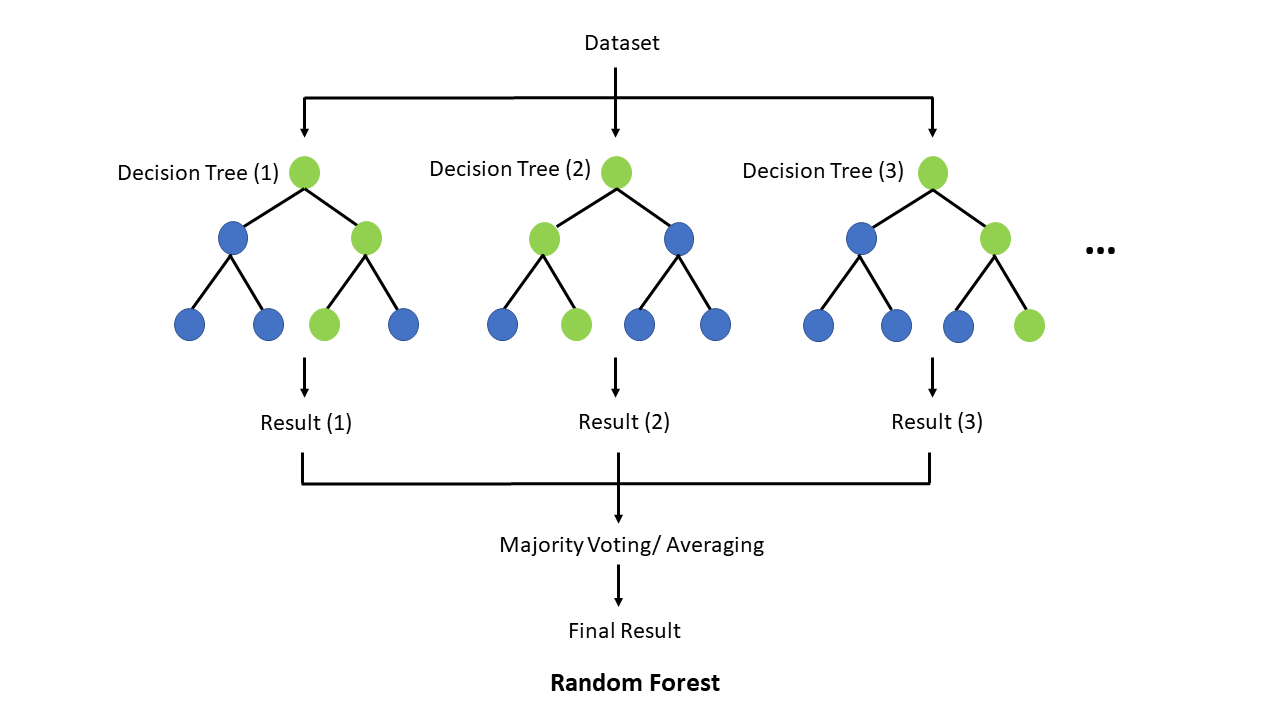


#### Training time
The training time for a RF is rather short since multiple trees can be trained at the same time (parallel)

#### 5.5.1.1 Hyperparameter tuning

#### What hyperparameters to choose

For RF models, we can adjust several hyperparameters to improve model performance. The key hyperparameters include:

    n_estimtors (penalty):
        Specifies how many trees are built in the forest.

    max_depth:
        Controls the depth of each tree.

    max_features:
        Controls how many features should be considered when trying to find the best split

    criterion:
        Selects the loss function to measure model outcome. 

In [403]:
rf = RandomForestClassifier()

param_grid = {'n_estimators': [50], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'max_features': ['auto', 'sqrt', 'log2'], 'bootstrap': [True]}
rf_cv = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, scoring='f1', n_jobs=-1)

#### 5.5.1.2 Training RF

In [ ]:
rf_cv.fit(X_train, y_train)
print("Best parameters: ", rf_cv.best_params_)
print("Best cross-validation score: ", rf_cv.best_score_)

#### 5.5.1.3 Predicting RF

In [405]:
rf_pred = rf_cv.predict(test_data)

rf_pred_df = test_data_ids.to_frame()
rf_pred_df['stroke'] = rf_pred

#### 5.5.1.4 Writing to CSV

In [406]:
rf_pred_df.to_csv('Datasets/Predictions/rf_pred.csv', index=False)

### 5.5.2 Gradient Boosting Classifier

#### General

In principle, a GBoost model works the same as a RF model. Both build trees to enhance their predictions. The key difference is the ensemble technique used to build trees. While RF, uses bagging, GBoost and XGBoost utilize a technique called boosting. Boosting in the context of GBC means that each new tree is trained to correct the residual (difference between predicted and actual values) errors of all earlier trees. This technique aims to improve the overall model accuracy by combining the predictions of each tree.

#### Training time

The trees in a GBC are built sequentially because each newly built tree is based on the output of the prior tree. This leads to a longer training time since the process cannot be done parallel.

#### 5.5.2.1 Hyperparameter tuning

#### Which hyperparamters to choose

For GB models, we can adjust several hyperparameters to improve model performance. The key hyperparameters include:

    n_estimators (penalty):
        Specifies how many trees are built in the forest.

    max_depth:
        Controls the depth of each tree.

    max_features:
        Controls how many features should be considered when trying to find the best split
    
    loss: Chooses how the model penalizes errors

    criterion: Guides the decision tree construction by selecting the best splits to minimize the chosen loss function.

In [407]:
gb = GradientBoostingClassifier()

param_grid = {'loss': ['log_loss', 'exponential'], 'n_estimators': [50], 'criterion': ['friedman_mse', 'squared_error'], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'max_features': ['sqrt', 'log2']}
gb_cv = GridSearchCV(estimator=gb, param_grid=param_grid, cv=10, scoring='f1', n_jobs=-1)

#### 5.5.2.2 Training GB

In [ ]:
gb_cv.fit(X_train, y_train)
print("Best parameters: ", gb_cv.best_params_)
print("Best cross-validation score: ", gb_cv.best_score_)

#### 5.5.2.3 Predicting GB

In [409]:
gb_pred = gb_cv.predict(test_data)

gb_pred_df = test_data_ids.to_frame()
gb_pred_df['stroke'] = gb_pred

#### 5.5.2.4 Writing to CSV

In [410]:
gb_pred_df.to_csv('Datasets/Predictions/gb_pred.csv', index=False)

### 5.5.3 XGBoost

#### General

XGBoost can be seen as an optimized version of GB. The principle is the same as it aims to correct the errors made by earlier trees (=Boosting). However, XGB introduces some improvents like Regularization (L1 and L2), tries to handle weighted and missing data better. 

#### Training time

The trees in a XGBC are built sequentially because each newly built tree is based on the output of the prior tree. However, XGBoost is not strictly sequential. While it still builds each tree sequentially, the building of each individual tree is improved. The search for the best split for example is parallelized (the evualation of features is distributed over different processors). This "hybrid" attempt reduces the training time of a XGBoost model compared to a GB model. 

#### 5.5.3.1 Hyperparameter tuning

#### What hyperparameters to choose

For GB models, we can adjust several hyperparameters to improve model performance. The key hyperparameters include:

    n_estimators:
        Specifies how many trees are built in the forest.

    max_depth:
        Controls the depth of each tree.

    learning_rate:
        Controls how much each tree contributes to the result.
    
    gamma: Minimum loss reduction required to make a further split.

    subsample: how much of the training sample is used to build each tree.

    objective: specifies the learning task and loss function that the model should optimize. 

In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

param_grid = {
    'n_estimators': [50],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'objective': ['binary:logistic'],
}

xgb_cv = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=10, scoring='f1', n_jobs=-1)

#### 5.5.3.2 Training XGB

In [ ]:
xgb_cv.fit(X_train, y_train)
print("Best parameters: ", xgb_cv.best_params_)
print("Best cross-validation score: ", xgb_cv.best_score_)

#### 5.5.3.3 Predicting XGB

In [ ]:
xgb_pred = xgb_cv.predict(test_data)

xgb_pred_df = test_data_ids.to_frame()
xgb_pred_df['stroke'] = xgb_pred

#### 5.5.3.4 Writing to CSV

In [ ]:
xgb_pred_df.to_csv('Datasets/Predictions/xgb_pred.csv', index=False)

### 5.5.4 Self-composed Ensemble

#### 5.5.4.1 Hyperparameter tuning

#### 5.5.4.2 Training the self-composed Ensemble

#### 5.5.4.3 Predicting the self-composed Ensemble

#### 5.5.4.4 Writing to CSV

## 6. Deciding feature importances

In [ ]:
#lr_fi = lr_cv.best_estimator_.coef_
#dt_fi = dt_cv.best_estimator_.feature_importances_
#rf_fi = rf_cv.best_estimator_.feature_importances_
#gb_fi = gb_cv.best_estimator_.feature_importances_
#
#fi_df = pd.DataFrame({'Features': X_train.columns, 'LR': lr_fi[0], 'DT': dt_fi, 'RF': rf_fi, 'GB': gb_fi})
#fi_df['LR'] = np.abs(fi_df['LR'])
#fi_df['mean'] = fi_df.mean(axis=1)
#
#fi_df = fi_df.sort_values(by='mean', ascending=False)
#
#fig, ax = plt.subplots(figsize=(20, 6))
#ax.axis('tight')
#ax.axis('off')
#ax.table(cellText=fi_df.values, colLabels=fi_df.columns, cellLoc='center', loc='center')
#
#ax.set_title("Feature Importance Table (Run 1 with all features)", fontsize=16, fontweight='bold')
#
#plt.savefig('Figures/output_table_2.png', format='png')
#
#plt.show()